In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
import argparse
import dlib
import cv2
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import imutils
from imutils import face_utils
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D,AveragePooling2D ,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/dataset.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
train_dir = "/content/dataset/train"
validation_dir = "/content/dataset/val"
test_dir = "/content/dataset/test"

image_size = 128

In [6]:
#Data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255,
                                        zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 32
val_batchsize = 16

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Data Generator for Test data
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)


Found 24000 images belonging to 24 classes.
Found 2400 images belonging to 24 classes.
Found 2400 images belonging to 24 classes.


In [7]:
resnet = ResNet50(input_shape= (128,128,3),include_top=False,weights='imagenet')
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [8]:
headModel = resnet.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(832, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(24, activation="softmax")(headModel)
model = Model(inputs=resnet.input, outputs=headModel)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor = 'val_loss',
                          min_delta = 0, #minimium amount of change to count as an improvement
                          patience = 10, # how many epochs to wait before stopping
                          verbose = 1,
                          restore_best_weights = True),
    ReduceLROnPlateau(factor=0.9, patience=10, min_lr=0.0001),
    ModelCheckpoint('resnet50.h5', verbose=1, save_best_only=True)#, save_weights_only=True
]

In [10]:
# Train the Model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1,callbacks=callbacks)

Epoch 1/100
750/750 [==============================] - ETA: 0s - loss: 0.1941 - acc: 0.9482
Epoch 1: val_loss improved from inf to 2.59997, saving model to resnet.h5
750/750 [==============================] - 161s 187ms/step - loss: 0.1941 - acc: 0.9482 - val_loss: 2.6000 - val_acc: 0.4821 - lr: 1.0000e-04
Epoch 2/100
750/750 [==============================] - ETA: 0s - loss: 0.0394 - acc: 0.9935
Epoch 2: val_loss did not improve from 2.59997
750/750 [==============================] - 135s 179ms/step - loss: 0.0394 - acc: 0.9935 - val_loss: 7.3602 - val_acc: 0.6608 - lr: 1.0000e-04
Epoch 3/100
750/750 [==============================] - ETA: 0s - loss: 0.0363 - acc: 0.9954
Epoch 3: val_loss did not improve from 2.59997
750/750 [==============================] - 135s 180ms/step - loss: 0.0363 - acc: 0.9954 - val_loss: 5.7300 - val_acc: 0.6354 - lr: 1.0000e-04
Epoch 4/100
750/750 [==============================] - ETA: 0s - loss: 0.0194 - acc: 0.9965
Epoch 4: val_loss did not improve from

## Model Evaluation

In [11]:
eval_result =model.evaluate(test_generator)
print("[test loss, test accuracy]:", eval_result)

150/150 [==============================] - 4s 25ms/step - loss: 0.2869 - acc: 0.9513
[test loss, test accuracy]: [0.28691479563713074, 0.9512500166893005]


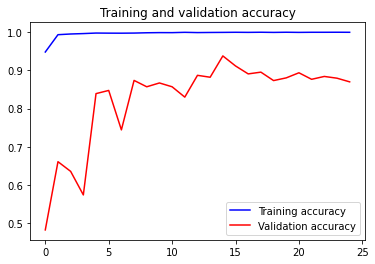

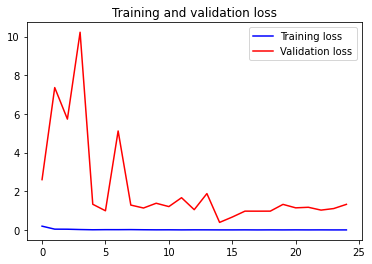

In [12]:
## Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())


In [24]:
# Get the predictions from the model using the generator
predictions = model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)


150/150 [==============================] - 3s 22ms/step


In [25]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       100
           1       1.00      0.93      0.96       100
           2       1.00      1.00      1.00       100
           3       1.00      0.91      0.95       100
           4       0.97      1.00      0.99       100
           5       0.98      1.00      0.99       100
           6       1.00      0.98      0.99       100
           7       0.99      1.00      1.00       100
           8       0.94      0.98      0.96       100
           9       1.00      1.00      1.00       100
          10       1.00      1.00      1.00       100
          11       0.96      0.99      0.98       100
          12       0.94      0.84      0.89       100
          13       0.95      0.99      0.97       100
          14       0.97      1.00      0.99       100
          15       1.00      0.97      0.98       100
          16       0.96      0.97      0.97       100
          17       0.79    

In [26]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

No of errors = 117/2400


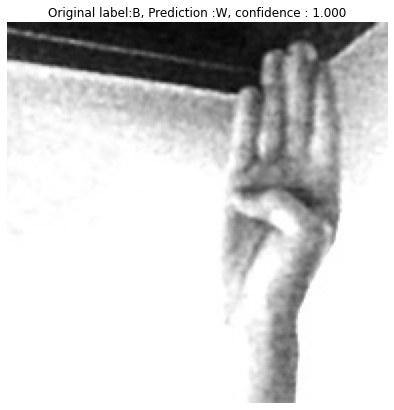

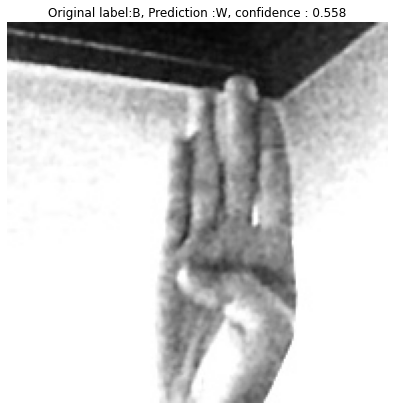

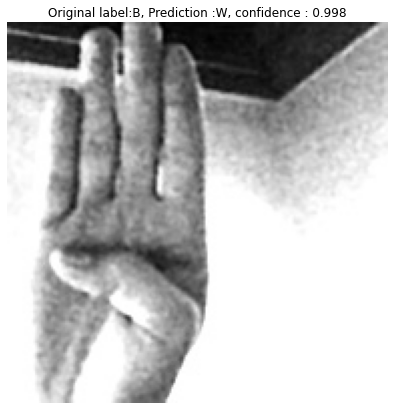

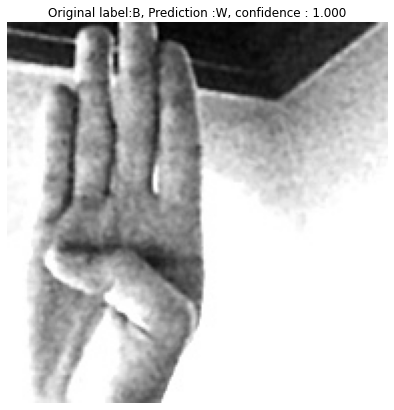

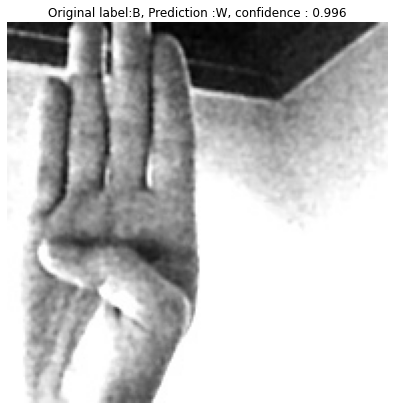

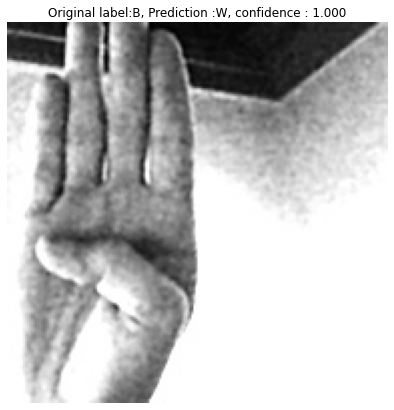

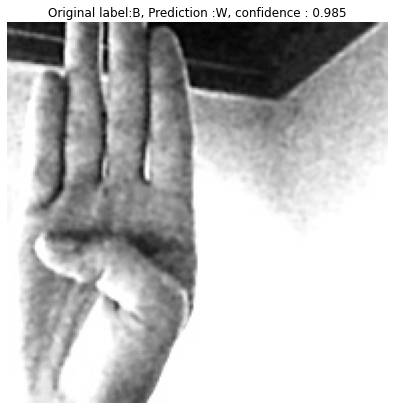

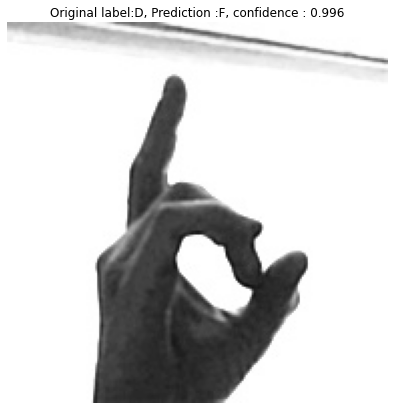

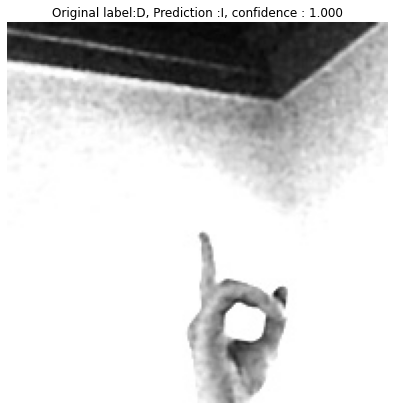

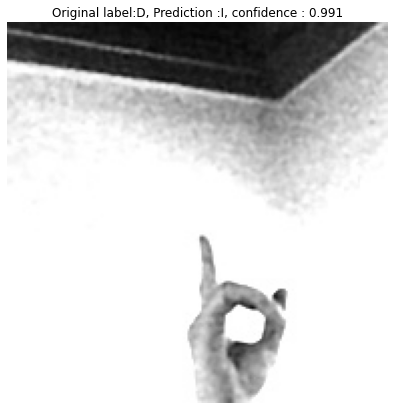

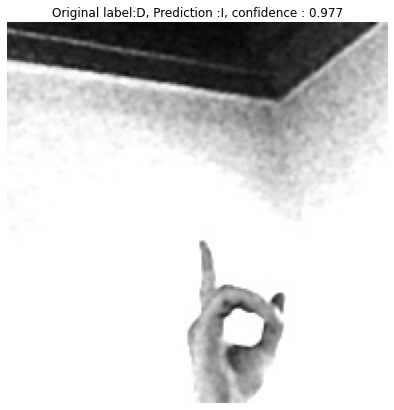

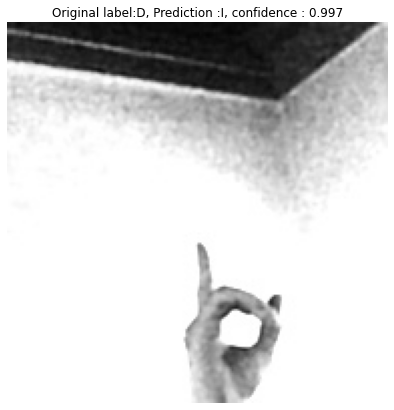

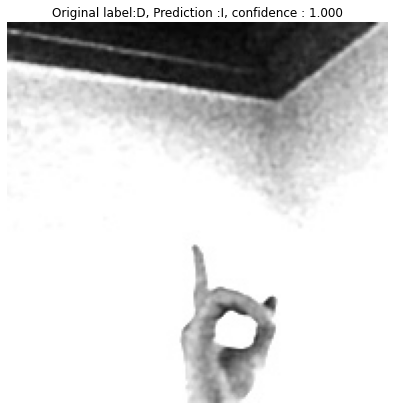

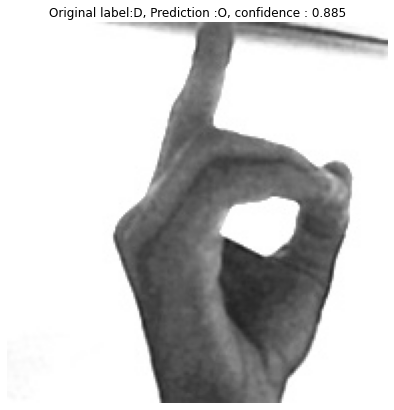

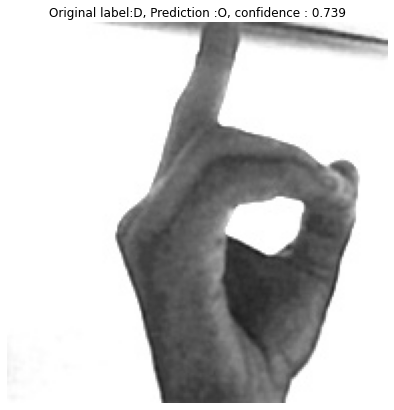

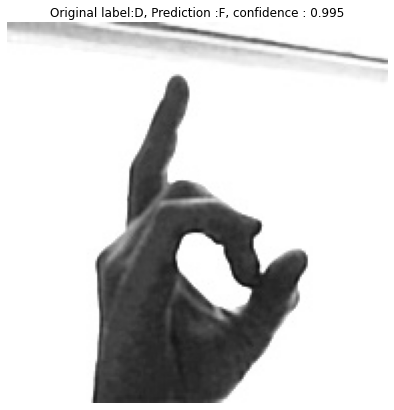

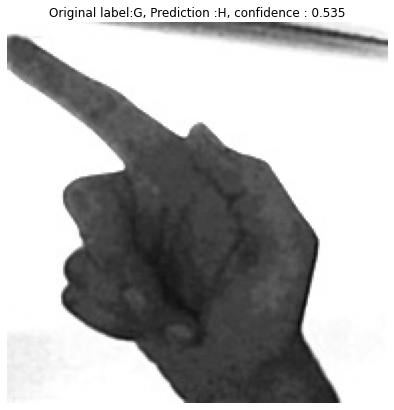

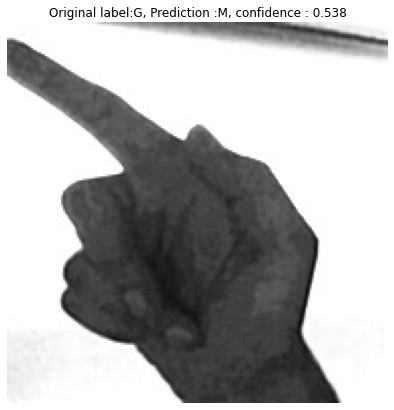

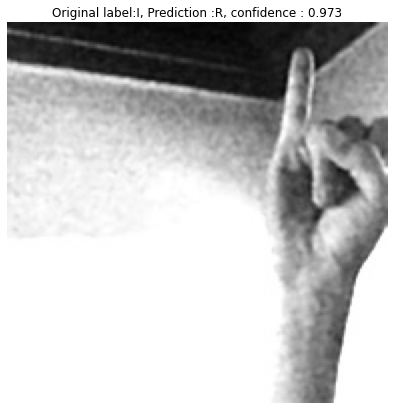

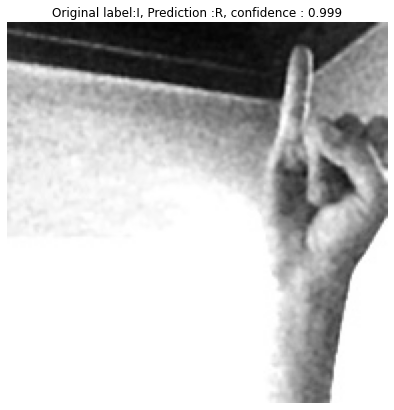

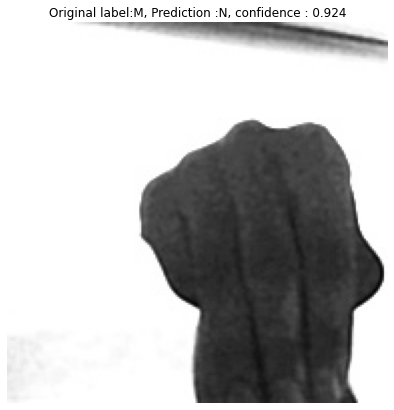

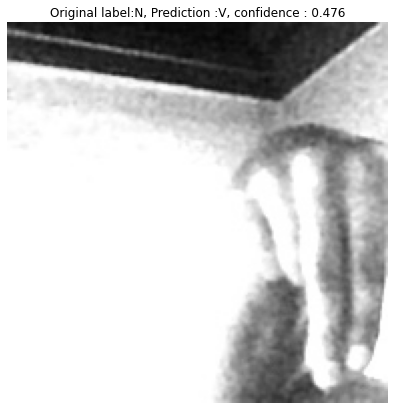

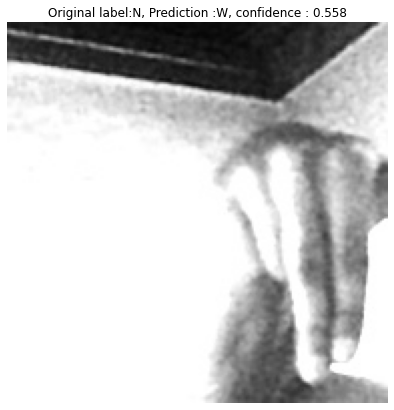

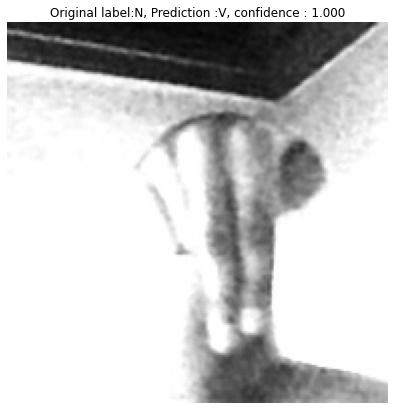

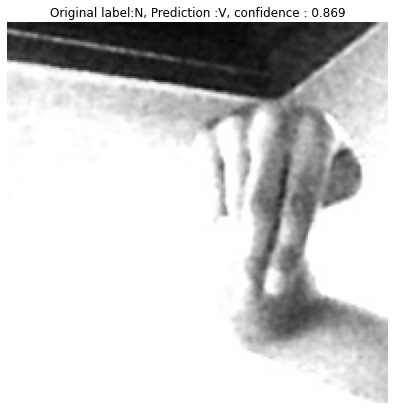

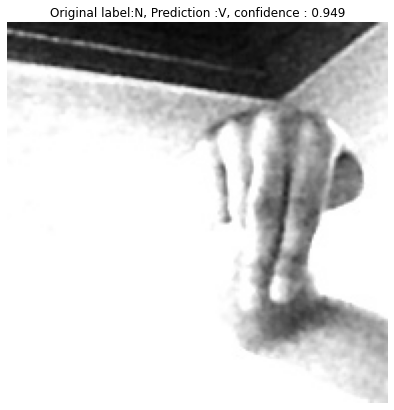

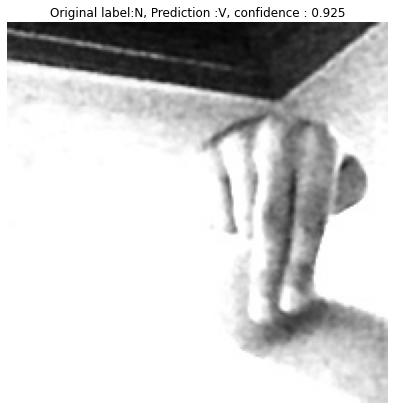

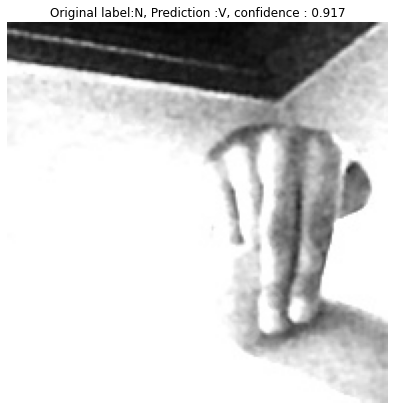

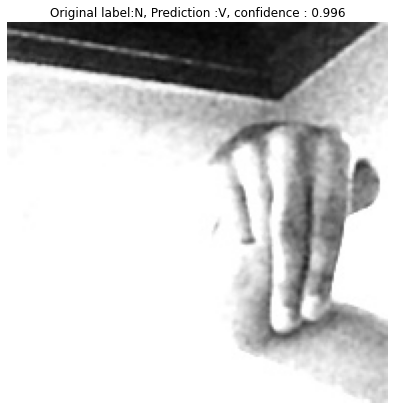

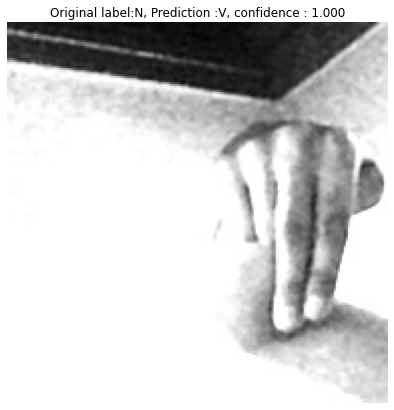

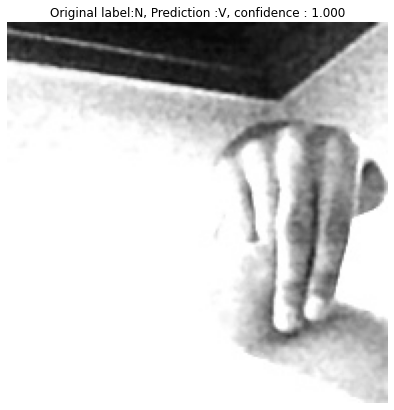

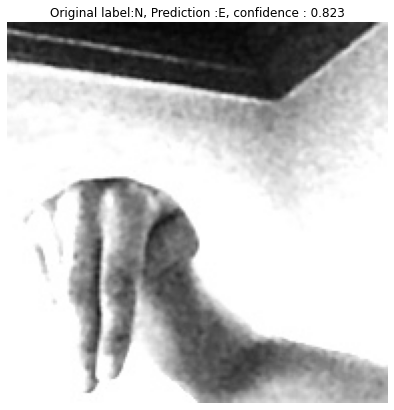

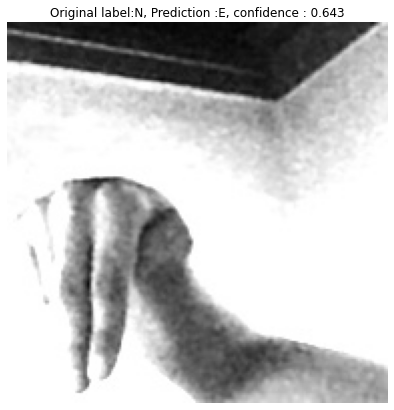

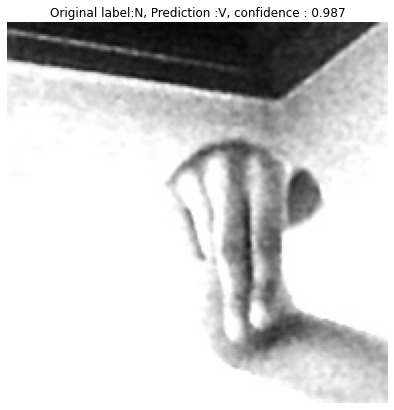

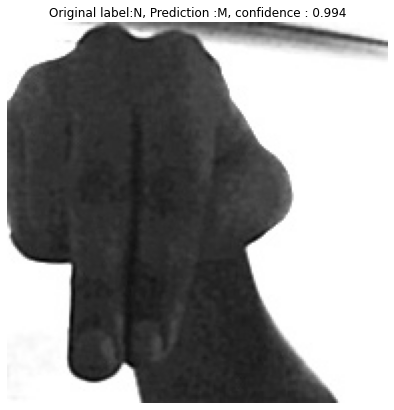

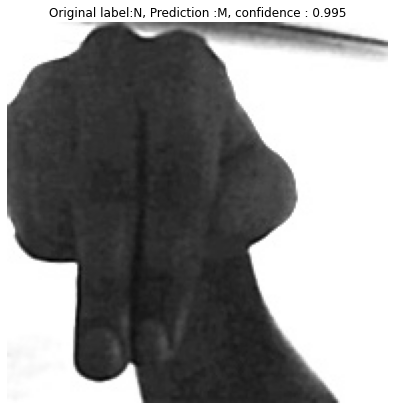

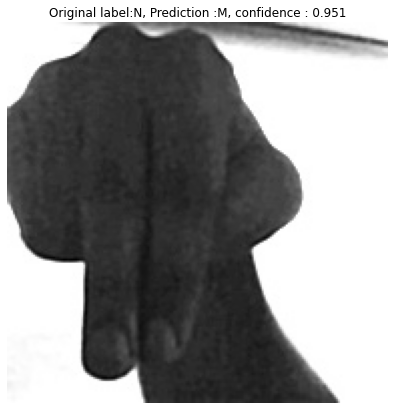

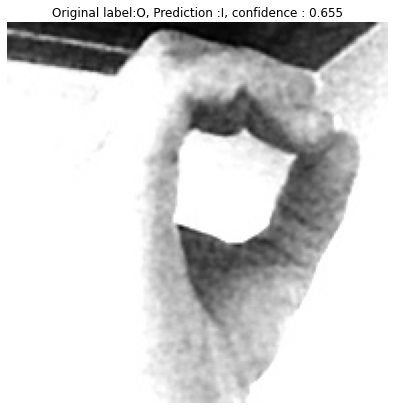

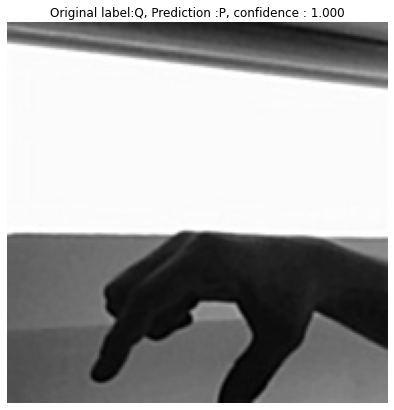

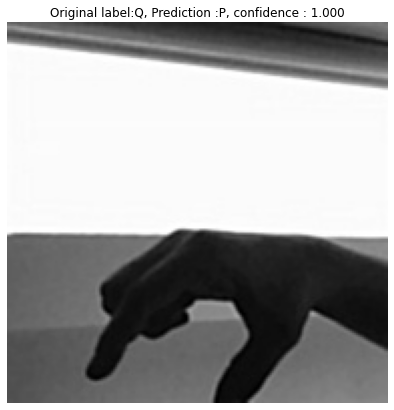

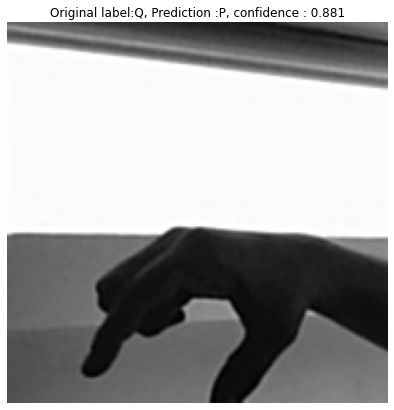

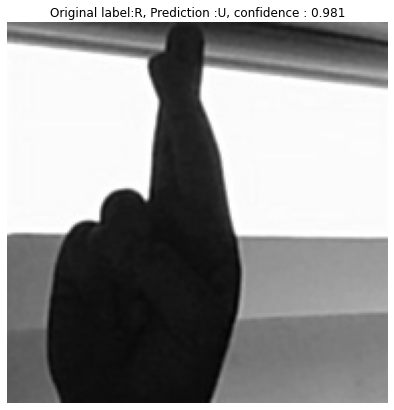

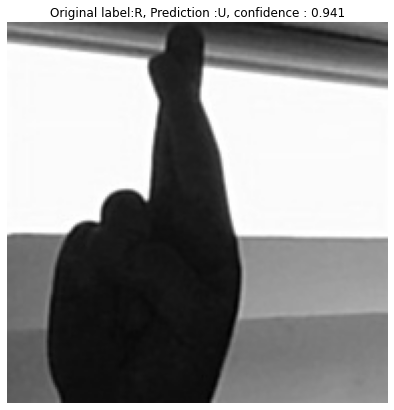

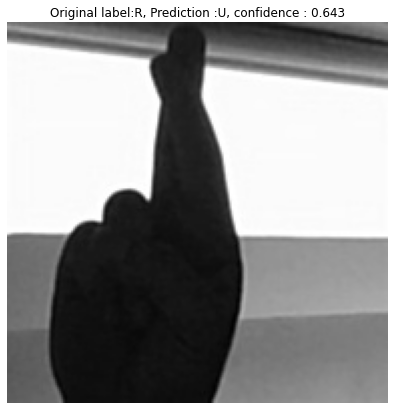

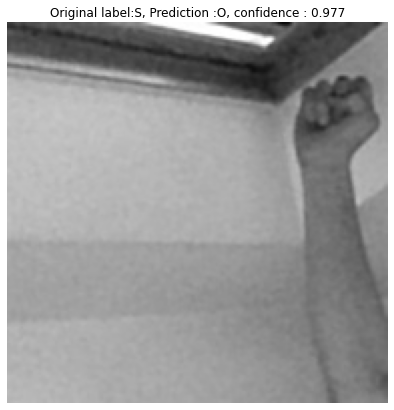

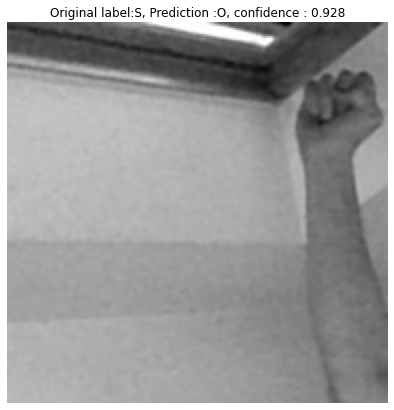

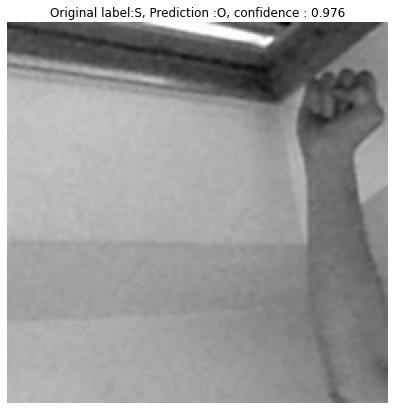

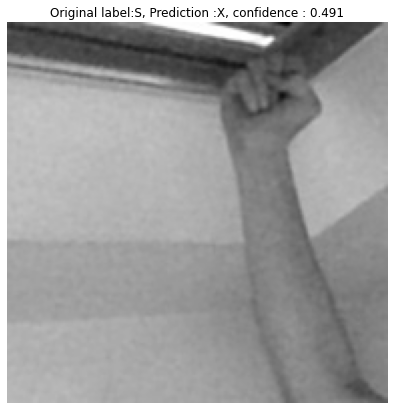

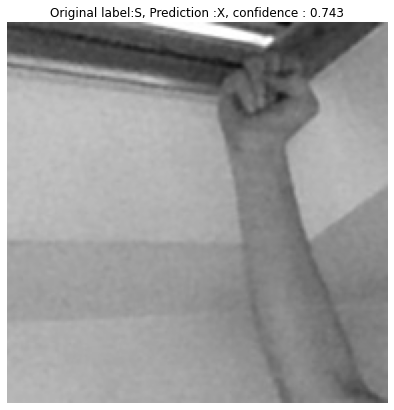

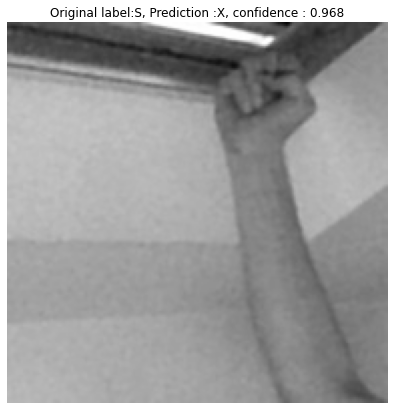

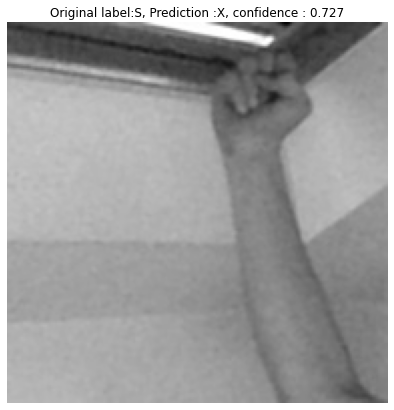

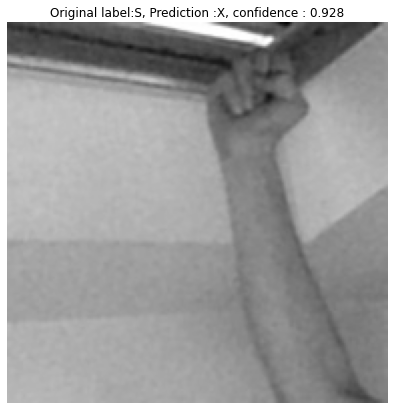

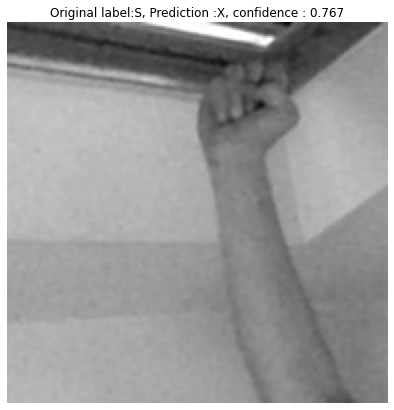

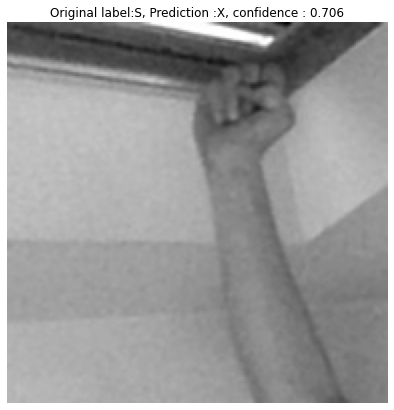

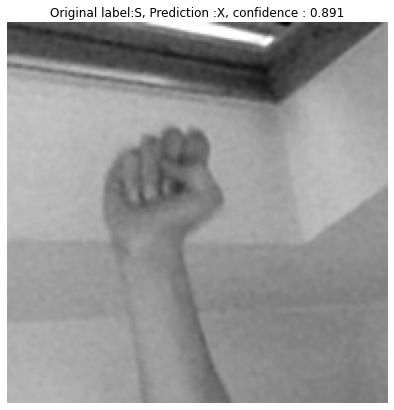

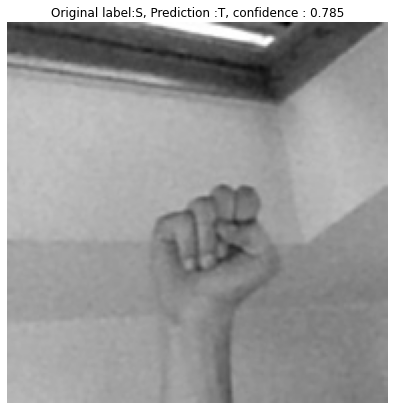

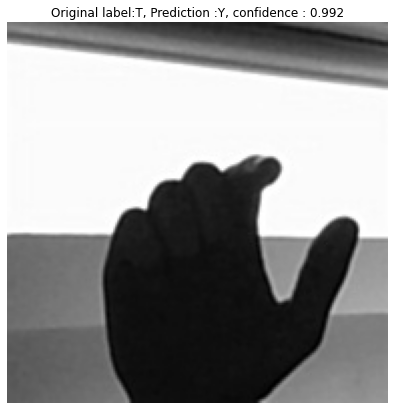

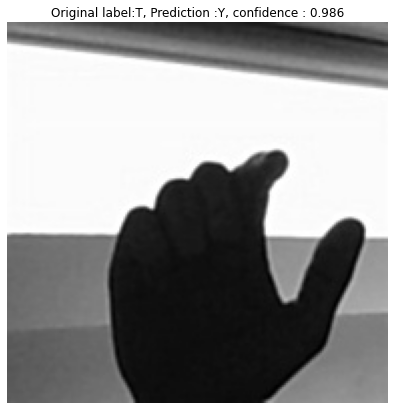

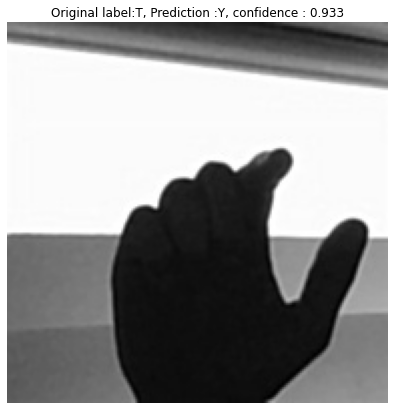

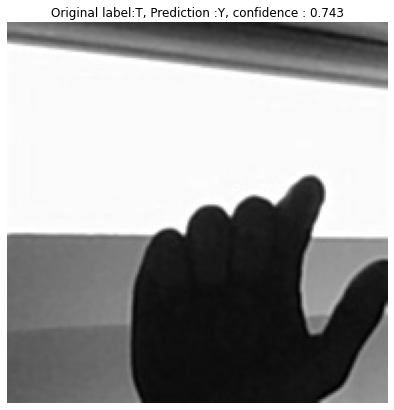

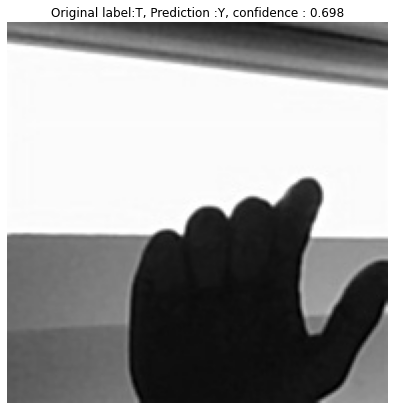

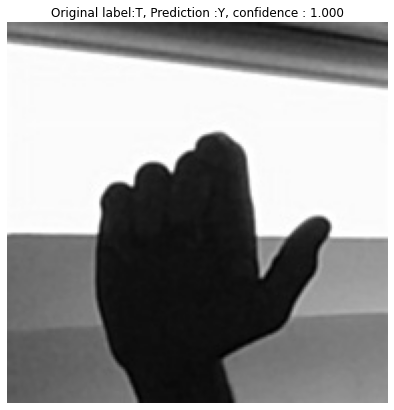

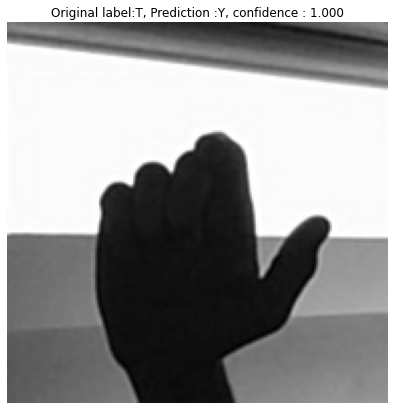

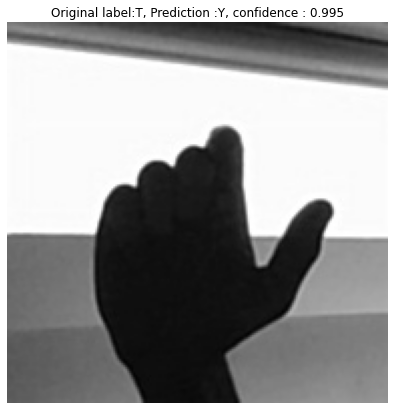

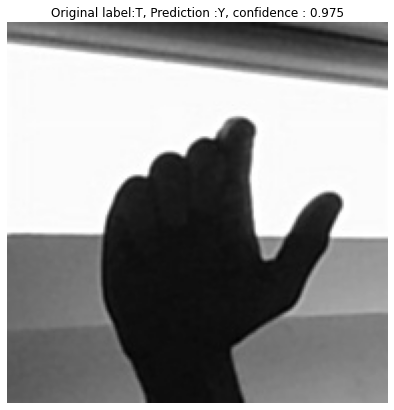

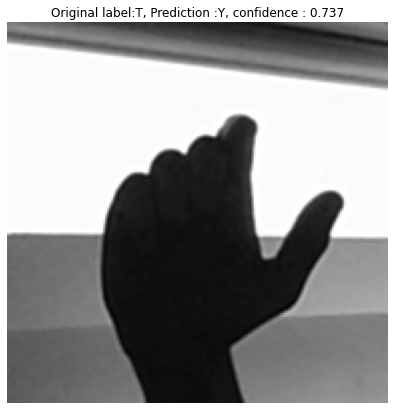

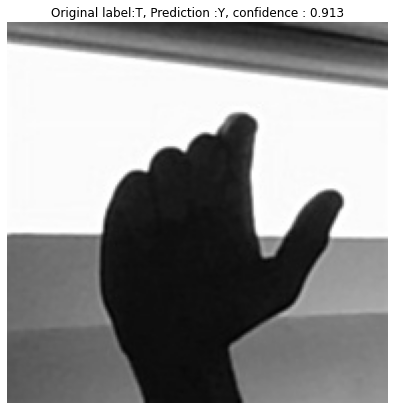

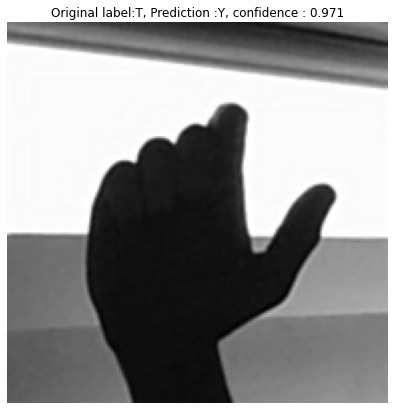

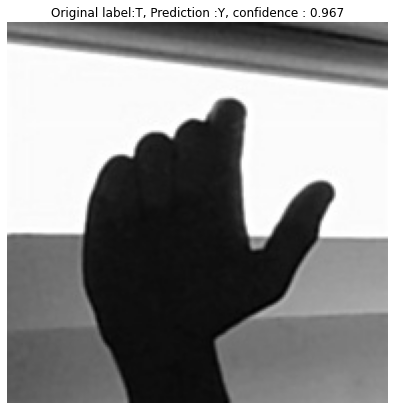

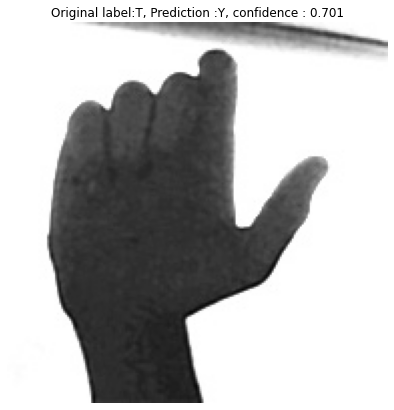

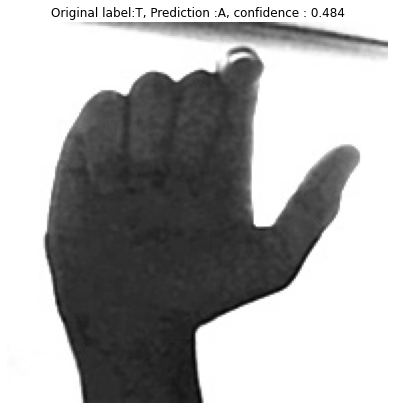

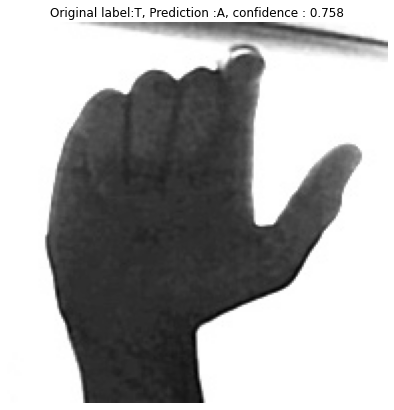

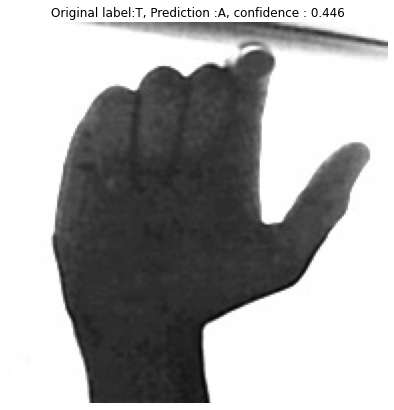

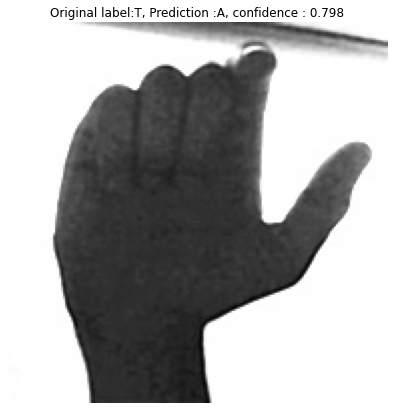

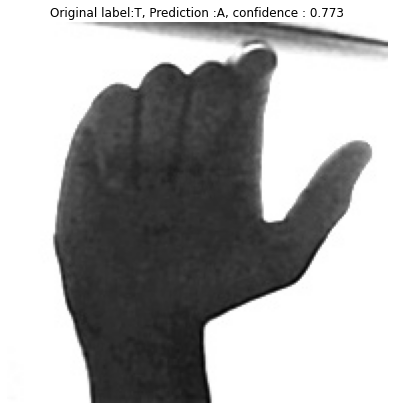

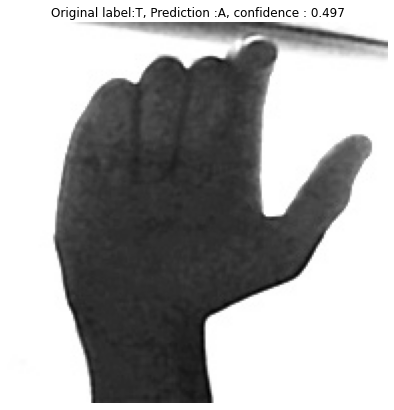

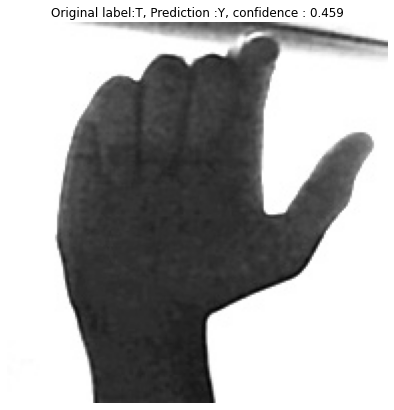

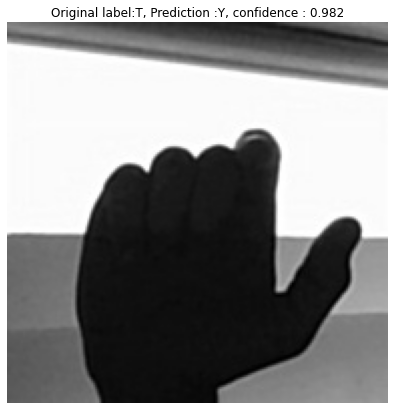

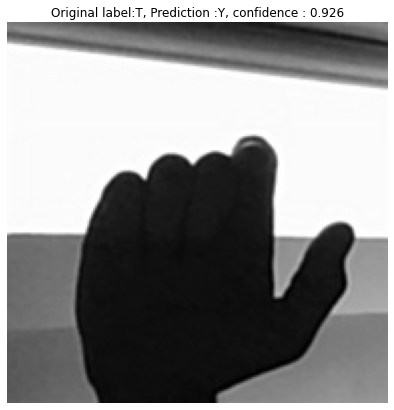

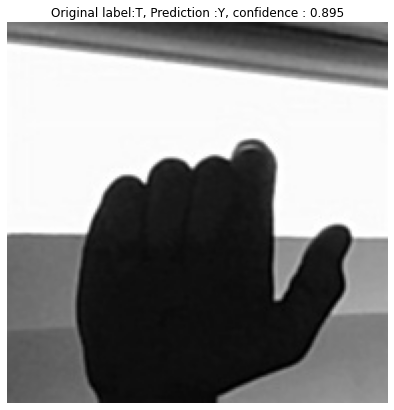

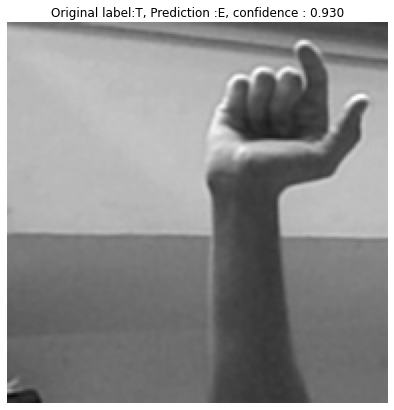

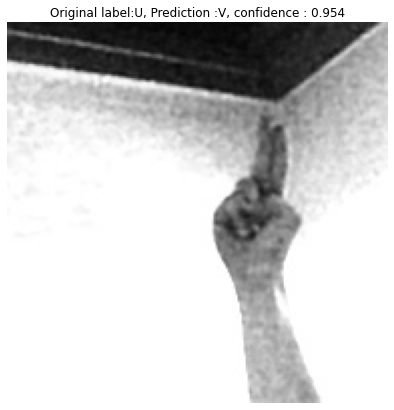

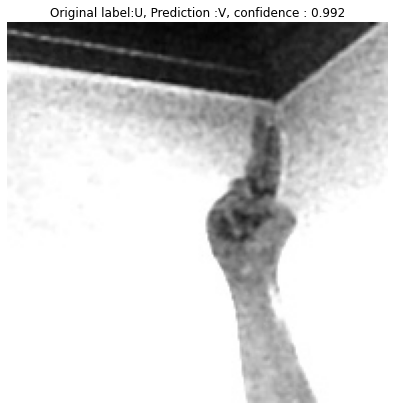

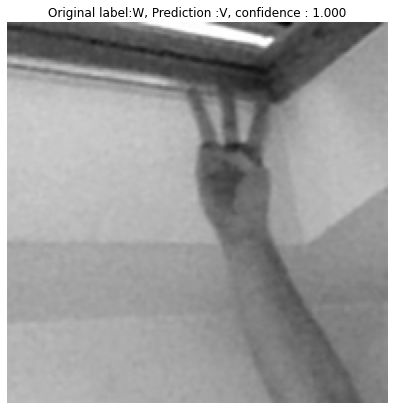

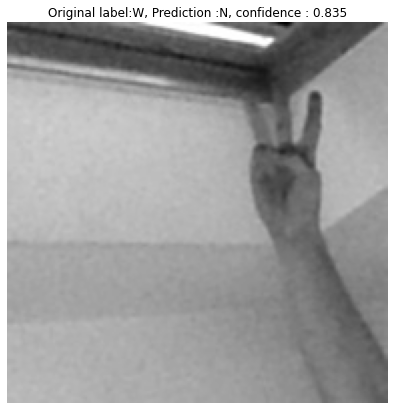

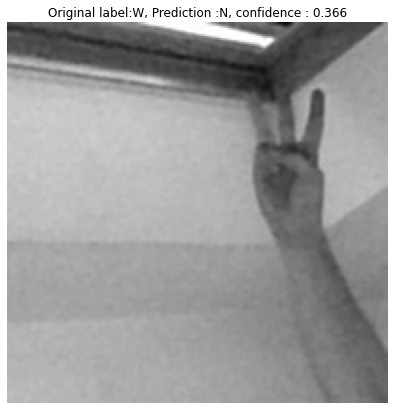

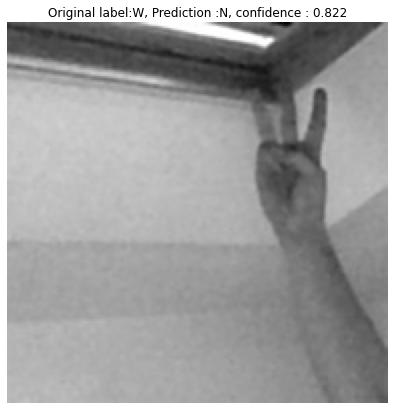

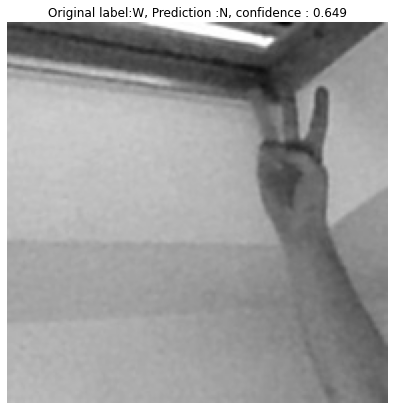

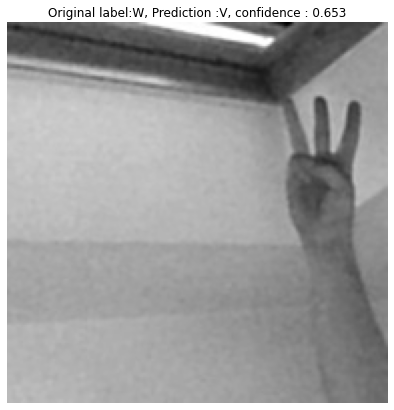

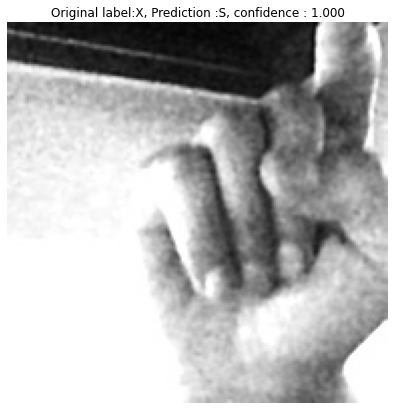

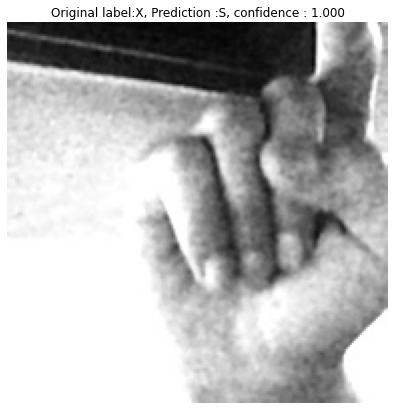

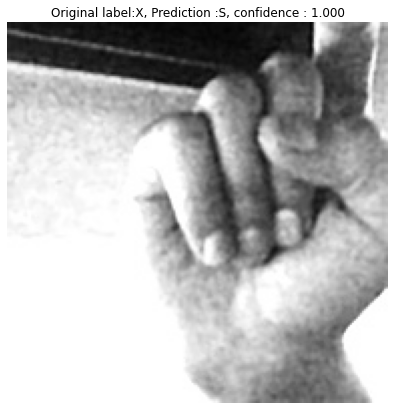

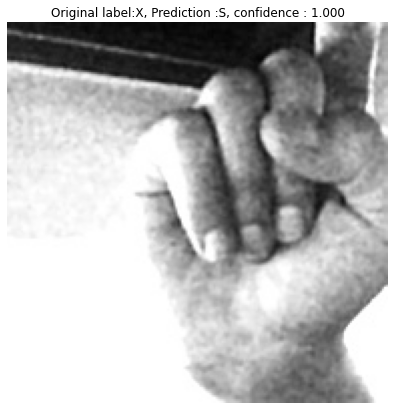

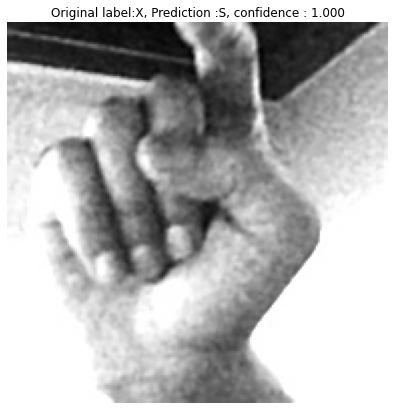

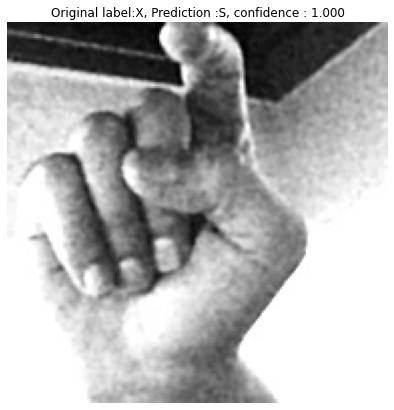

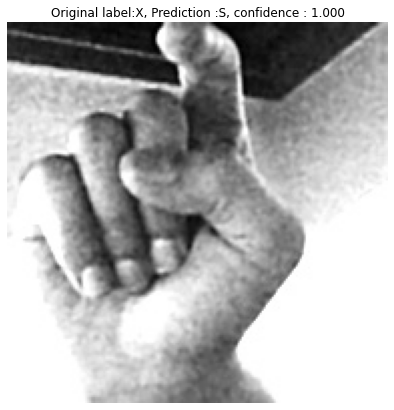

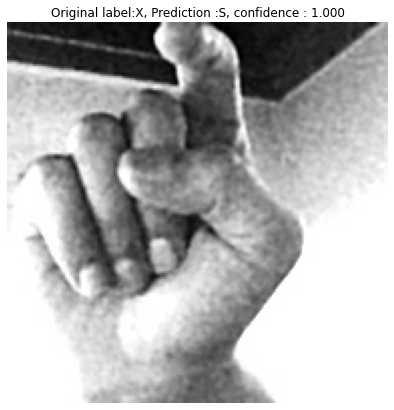

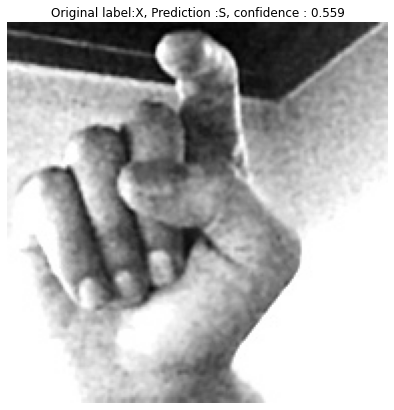

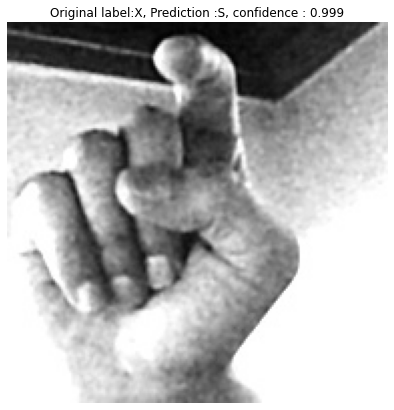

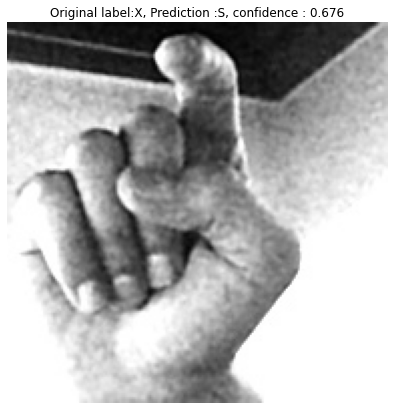

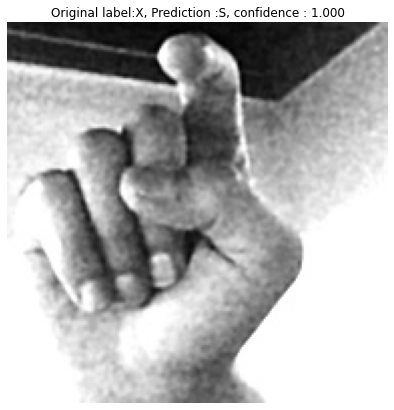

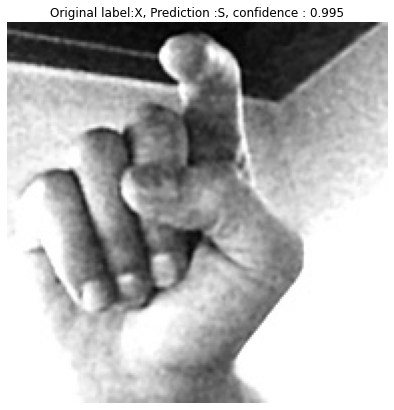

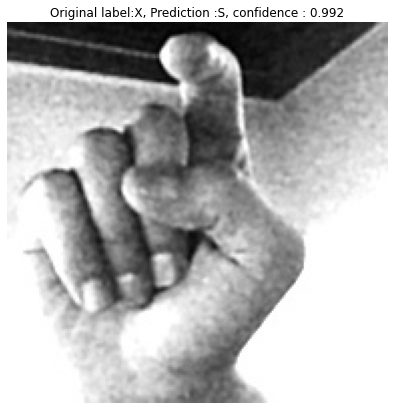

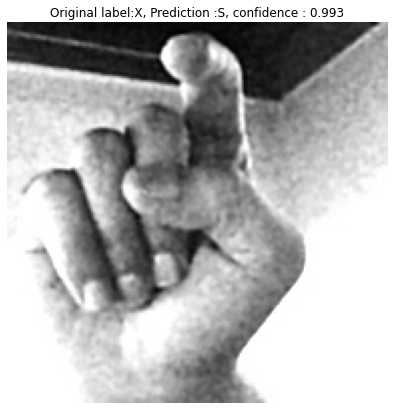

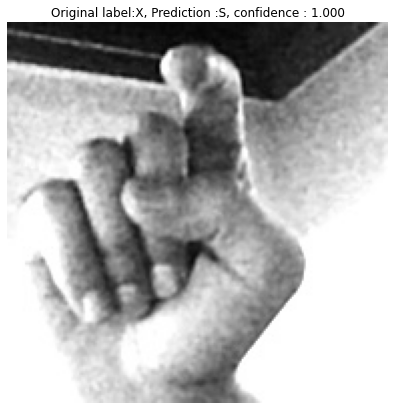

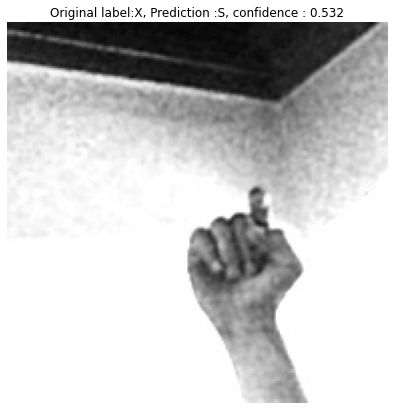

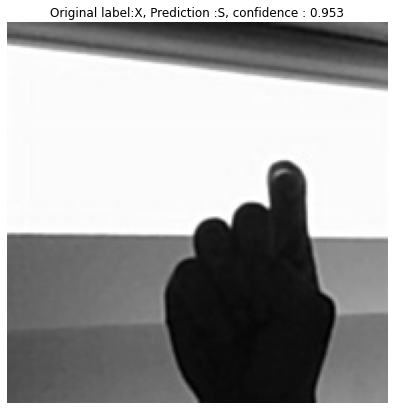

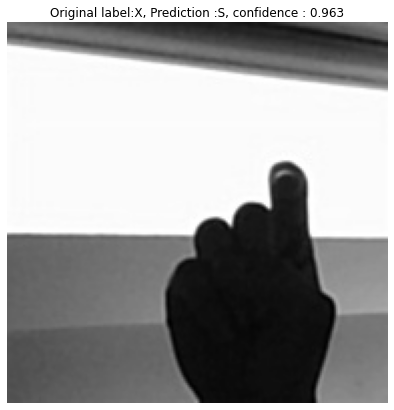

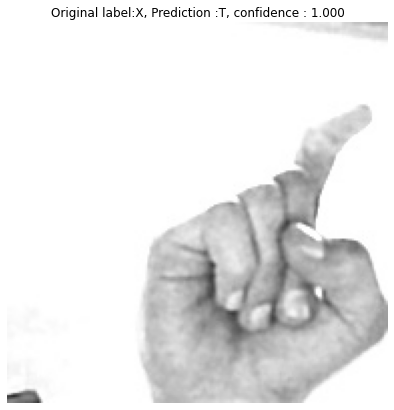

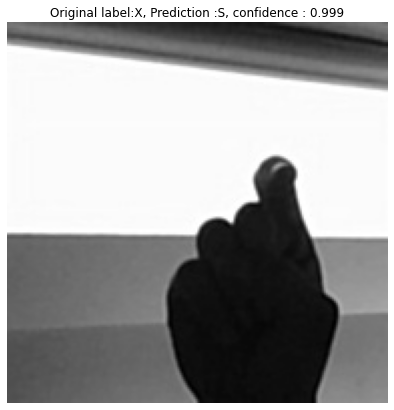

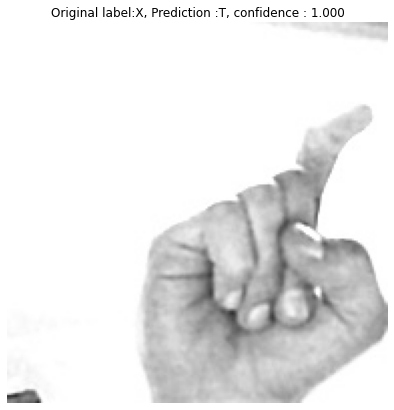

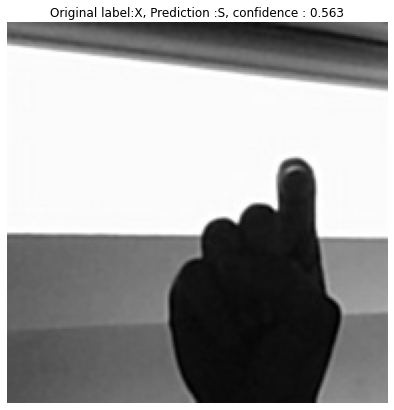

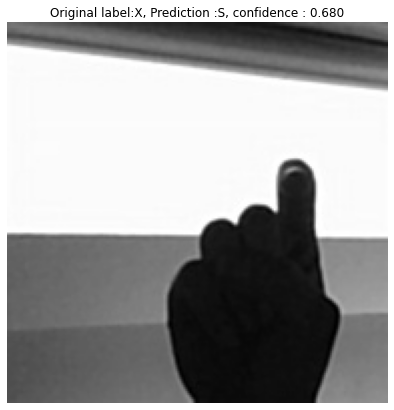

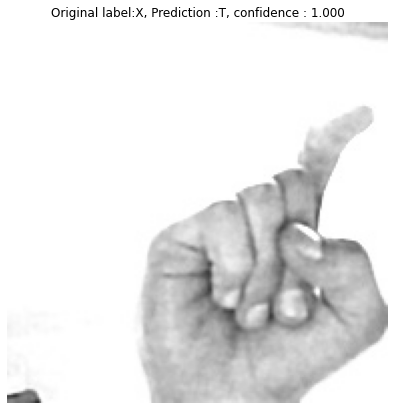

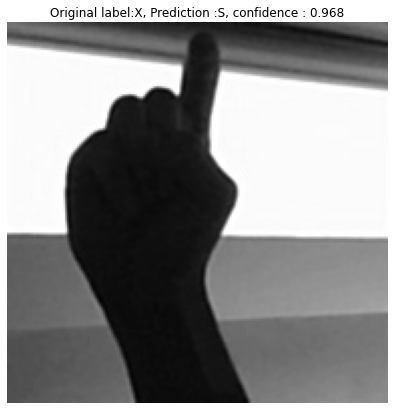

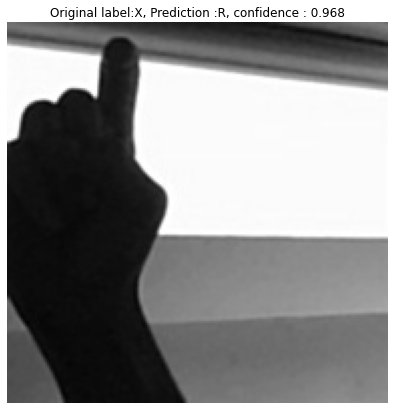

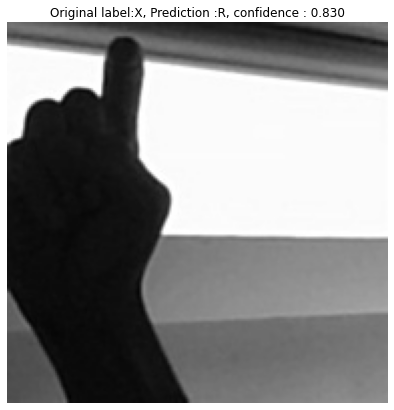

In [27]:
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()